<a href="https://colab.research.google.com/github/MariaLimaS/IHC/blob/main/Treinamento_Detec%C3%A7%C3%A3o_Emo%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importando as bibliotecas

In [1]:
# Importa a biblioteca OpenCV para processamento de imagens
import cv2

# Importa a biblioteca NumPy para manipulação de arrays
import numpy as np

# Importa a biblioteca Pandas para manipulação e análise de dados em formato tabular
import pandas as pd

# Importa a biblioteca Matplotlib para criação de visualizações e gráficos a partir de dados
import matplotlib.pyplot as plt

# Importa a função cv2_imshow do pacote google.colab.patches para exibir imagens no ambiente Colab
from google.colab.patches import cv2_imshow

# O TensorFlow é uma biblioteca amplamente usada para criação e treinamento de modelos de aprendizado de máquina, incluindo redes neurais
import tensorflow as tf


In [2]:
#Para conectar com o google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Acessando a base de expressões faciais de emoções do FER2013



In [3]:
# Lê um arquivo CSV contendo dados do caminho '/content/drive/MyDrive/TCC/fer2013.csv' e carrega-o em um DataFrame do Pandas
data = pd.read_csv('/content/drive/MyDrive/TCC/fer2013.csv')

# Exibe as últimas linhas (por padrão, as últimas 5) do DataFrame 'data' para verificar os dados carregados
data.tail()


,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


## Análise e visualização da distribuição dos dados

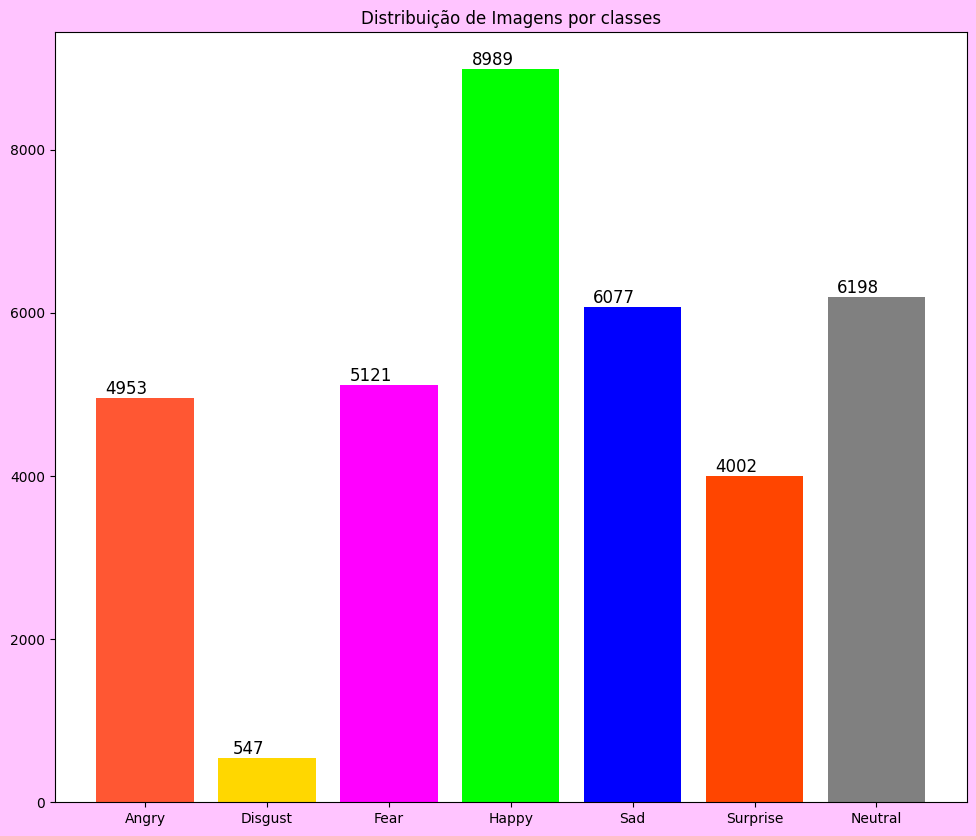

In [4]:
# Cria uma figura para exibir um gráfico, definindo o tamanho da figura como (40, 10)
fig = plt.figure(figsize=(40, 10))

# Define a cor de fundo da figura como '#ffc4ff'
fig.patch.set_facecolor('#ffc4ff')

# Define os nomes das classes de emoções em uma lista
names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Inicializa uma lista 'categoria' com contagens zeradas para cada classe de emoção
categoria = [0, 0, 0, 0, 0, 0, 0]

# Loop através das emoções no DataFrame 'data' e atualiza as contagens na lista 'categoria'
for emotion in data.emotion:
    categoria[emotion] += 1

# Cria um subplot (um subgráfico) com 1 linha e 3 colunas, selecionando o primeiro subgráfico (131)
plt.subplot(131)

# Define o título do subgráfico como "Distribuição de Imagens por classes"

# Define as cores das barras em uma lista
colors = ['#FF5733', '#FFD700', '#FF00FF', '#00FF00', '#0000FF', '#FF4500', '#808080']

# Cria um gráfico de barras (histograma) com os nomes das classes no eixo x, as contagens (categoria) no eixo y e cores personalizadas
bars = plt.bar(names, categoria, color=colors)

# Adiciona rótulos com as contagens nas barras do gráfico
for bar, count in zip(bars, categoria):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.5, str(count), ha='center', va='bottom', fontsize=12)

# Exibe o gráfico
plt.show()


##  Pré-processamento dos dados do arquivo para utilização na CNN

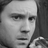

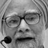

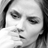

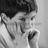

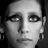

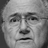

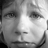

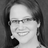

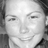

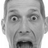

In [4]:
# Obtém a coluna 'pixels' do DataFrame 'data' como uma lista de strings e a armazena na variável 'pixels'
pixels = data['pixels'].tolist()

# Define as dimensões (largura e altura) das imagens como 48x48 pixels
largura, altura = 48, 48

# Inicializa uma lista vazia chamada 'faces' para armazenar as imagens
faces = []

# Inicializa uma variável 'amostras' para contar o número de amostras processadas (começa em 0)
amostras = 0

# Itera pelas sequências de pixels nas amostras do conjunto de dados
for pixel_sequence in pixels:
    # Divide a sequência de pixels separados por espaços em uma lista de valores inteiros
    face = [int(pixel) for pixel in pixel_sequence.split(' ')]

    # Converte a lista em um array NumPy e redimensiona para o tamanho das imagens (48x48)
    face = np.asarray(face).reshape(largura, altura)

    # Adiciona a imagem à lista 'faces'
    faces.append(face)

    # Exibe as primeiras 10 amostras de imagens usando a função cv2_imshow (OpenCV)
    if (amostras < 10):
        cv2_imshow(face)

    # Incrementa o contador de amostras
    amostras += 1

# Converte a lista 'faces' em um array NumPy
faces = np.asarray(faces)

# Adiciona uma dimensão extra às imagens para criar uma representação de canal único
faces = np.expand_dims(faces, -1)

# Define uma função 'normalizar' para normalizar os valores dos pixels das imagens
def normalizar(x):
    x = x.astype('float32')
    x = x / 255.0
    return x

# Aplica a função de normalização às imagens do conjunto de dados
faces = normalizar(faces)

# Cria um DataFrame com as emoções do conjunto de dados e o converte em um array NumPy
emocoes = pd.get_dummies(data['emotion']).values


In [5]:
#Mostra a quantidados de dados no Dataset original
print("Número total de imagens no dataset: "+str(len(faces)))

Número total de imagens no dataset: 35887


## Importação do Tensorflow/Keras

In [6]:
# Importa a função 'train_test_split' do módulo 'model_selection' da biblioteca Scikit-Learn
from sklearn.model_selection import train_test_split

# Importa as classes e funções necessárias do módulo 'models' da biblioteca Keras (TensorFlow)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json


## Divisão dos conjuntos para treinamento, teste e validação

In [7]:
# Divide o conjunto de dados 'faces' e 'emocoes' em conjuntos de treinamento (x_train e y_train) e teste (x_test e y_test)
# A divisão é feita de forma que 20% dos dados sejam usados para teste (test_size=0.2)
# O parâmetro 'random_state' define a semente para garantir que a divisão seja replicável
x_train, x_test, y_train, y_test = train_test_split(faces, emocoes, test_size=0.2, random_state=42)

# Divide o conjunto de treinamento 'x_train' e 'y_train' em conjuntos de treinamento e validação
# Neste caso, 10% dos dados do conjunto original são usados para validação (test_size=0.125)
# O parâmetro 'random_state' também é definido para manter a replicabilidade da divisão
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=41)

# Imprime o número de imagens em cada conjunto (treinamento, teste e validação)
print("Número de imagens no conjunto de treinamento:", len(x_train))
print("Número de imagens no conjunto de testes:", len(x_test))
print("Número de imagens no conjunto de validação:", len(y_val))


Número de imagens no conjunto de treinamento: 25120
Número de imagens no conjunto de testes: 7178
Número de imagens no conjunto de validação: 3589


## Apresentação em gráfico da amostragem dos conjuntos de treinamento, teste e validação

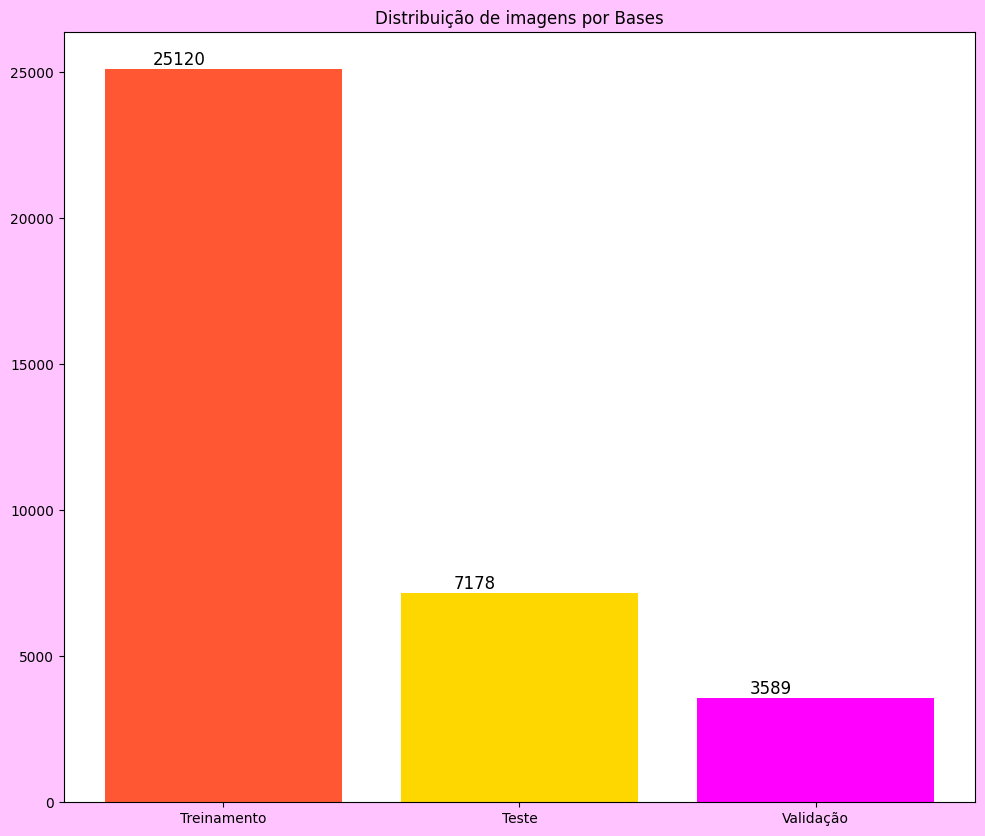

In [8]:
# Cria uma figura para o gráfico com o tamanho especificado (largura: 40 unidades, altura: 10 unidades)
fig = plt.figure(figsize=(40, 10))

# Define a cor de fundo da figura
fig.patch.set_facecolor('#ffc4ff')

# Nomes das categorias para os conjuntos de dados
names = ['Treinamento', 'Teste', 'Validação']

# Número de amostras em cada conjunto
categoria = [len(x_train), len(x_test), len(x_val)]

# Cria um subplot (1 linha, 3 colunas) na figura
plt.subplot(131)

# Define o título do subplot
plt.title("Distribuição de imagens por Bases")

# Define cores para as barras do gráfico
colors = ['#FF5733', '#FFD700', '#FF00FF']

# Plota as barras com cores e rótulos detalhados
bars = plt.bar(names, categoria, color=colors)

# Adiciona rótulos com os valores acima de cada barra
for bar, count in zip(bars, categoria):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.5, str(count), ha='center', va='bottom', fontsize=12)

# Exibe o gráfico
plt.show()


In [8]:
# Salva o array 'x_test' em um arquivo com nome 'mod_xtest.npy' usando o NumPy
np.save('mod_xtest', x_test)

# Salva o array 'y_test' em um arquivo com nome 'mod_ytest.npy' usando o NumPy
np.save('mod_ytest', y_test)


## Arquitetura do Modelo (CNN) proposto

In [26]:
# Define os valores dos hiperparâmetros do modelo
num_features = 128
num_classes = 7
width, height = 48, 48
batch_size = 32
epochs = 100

# Inicializa um modelo sequencial usando o Keras
model = Sequential()

# Adiciona camadas de convolução, ativação, normalização e pooling ao modelo
model.add(Conv2D(num_features, (3, 3), padding='same', kernel_initializer="he_normal",
                 input_shape=(width, height, 1), data_format='channels_last',
                 kernel_regularizer=l2(0.01)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(num_features, (3, 3), padding='same', kernel_initializer="he_normal",
                 kernel_regularizer=l2(0.01)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))


# Repete o padrão de camadas de convolução, ativação, normalização, pooling e dropout
# com variações nos números de recursos (features) e taxas de dropout
model.add(Conv2D(2*num_features, (3, 3), padding='same', kernel_initializer="he_normal",
                 input_shape=(width, height, 1), data_format='channels_last',
                 kernel_regularizer=l2(0.01)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(num_features, (3, 3), padding='same', kernel_initializer="he_normal",
                 kernel_regularizer=l2(0.01)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(2*2*num_features, (3, 3), padding='same', kernel_initializer="he_normal",
                 input_shape=(width, height, 1), data_format='channels_last',
                 kernel_regularizer=l2(0.01)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(num_features, (3, 3), padding='same', kernel_initializer="he_normal",
                 kernel_regularizer=l2(0.01)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(2*2*2*num_features, (3, 3), padding='same', kernel_initializer="he_normal",
                 input_shape=(width, height, 1), data_format='channels_last',
                 kernel_regularizer=l2(0.01)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(num_features, (3, 3), padding='same', kernel_initializer="he_normal",
                 kernel_regularizer=l2(0.01)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))


# Adiciona uma camada de achatamento (flatten) para transformar a saída em um vetor
model.add(Flatten())

# Adiciona camadas densas com ativação, normalização e dropout
model.add(Dense(2*2*2*num_features, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Repete o padrão com camadas densas e variações nos números de recursos
model.add(Dense(2*2*num_features, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2*num_features, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
# Finaliza o modelo com uma camada densa de saída com ativação softmax
model.add(Dense(num_classes, kernel_initializer="he_normal"))
model.add(Activation("softmax"))

# Imprime um resumo do modelo exibindo informações sobre as camadas e parâmetros
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 128)       1280      
                                                                 
 activation_12 (Activation)  (None, 48, 48, 128)       0         
                                                                 
 batch_normalization_11 (Ba  (None, 48, 48, 128)       512       
 tchNormalization)                                               
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 128)       147584    
                                                                 
 activation_13 (Activation)  (None, 48, 48, 128)       0         
                                                                 
 batch_normalization_12 (Ba  (None, 48, 48, 128)       512       
 tchNormalization)                                    

##Compilando o modelo

In [27]:
# Compila o modelo definindo a função de perda, otimizador e métricas a serem monitoradas
model.compile(loss=categorical_crossentropy,  # Usa a entropia cruzada categórica como função de perda
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),  # Otimizador Adam com parâmetros definidos
              metrics=['accuracy'])  # Monitora a precisão do modelo durante o treinamento

# Define o nome do arquivo para salvar o modelo treinado (pesos)
arquivo_modelo = "modelo_expressoes1.h5"

# Define o nome do arquivo JSON para salvar a arquitetura do modelo
arquivo_modelo_json = "modelo_expressoes1.json"

# Define callbacks para monitorar e ajustar o treinamento do modelo
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
# Reduz a taxa de aprendizado quando a perda na validação para de diminuir

early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
# Para o treinamento se a perda na validação não diminuir por um número de épocas definido

checkpointer = ModelCheckpoint(arquivo_modelo, monitor='val_loss', verbose=1, save_best_only=True)
# Salva o modelo com os melhores resultados na validação durante o treinamento


Salva a arquitetura do modelo em um arquivo JSON

In [28]:
# Converte a arquitetura do modelo em formato JSON
model_json = model.to_json()

# Abre o arquivo "arquivo_modelo_json" no modo de escrita ("w") para salvar a arquitetura
with open(arquivo_modelo_json, "w") as json_file:
    # Escreve a arquitetura do modelo no arquivo JSON
    json_file.write(model_json)


##Treinando o modelo

In [29]:
# Treina o modelo com os dados de treinamento e monitora o progresso
history = model.fit(np.array(x_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(x_val), np.array(y_val)),
          shuffle=True,
          callbacks=[lr_reducer, early_stopper, checkpointer])


Epoch 1/100
785/785 [==============================] - ETA: 0s - loss: 11.9226 - accuracy: 0.2583
Epoch 1: val_loss improved from inf to 2.26636, saving model to modelo_expressoes1.h5
785/785 [==============================] - 53s 56ms/step - loss: 11.9226 - accuracy: 0.2583 - val_loss: 2.2664 - val_accuracy: 0.3477 - lr: 0.0010
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


785/785 [==============================] - ETA: 0s - loss: 2.0892 - accuracy: 0.3292
Epoch 2: val_loss did not improve from 2.26636
785/785 [==============================] - 42s 54ms/step - loss: 2.0892 - accuracy: 0.3292 - val_loss: 2.3150 - val_accuracy: 0.1694 - lr: 0.0010
Epoch 3/100
785/785 [==============================] - ETA: 0s - loss: 1.9644 - accuracy: 0.3332
Epoch 3: val_loss improved from 2.26636 to 2.01592, saving model to modelo_expressoes1.h5
785/785 [==============================] - 43s 54ms/step - loss: 1.9644 - accuracy: 0.3332 - val_loss: 2.0159 - val_accuracy: 0.3363 - lr: 0.0010
Epoch 4/100
785/785 [==============================] - ETA: 0s - loss: 1.9841 - accuracy: 0.3341
Epoch 4: val_loss did not improve from 2.01592
785/785 [==============================] - 43s 55ms/step - loss: 1.9841 - accuracy: 0.3341 - val_loss: 2.2227 - val_accuracy: 0.2622 - lr: 0.0010
Epoch 5/100
785/785 [==============================] - ETA: 0s - loss: 2.0168 - accuracy: 0.3244
Ep

## Gerando gráfico da melhora em cada etapa do treinamento

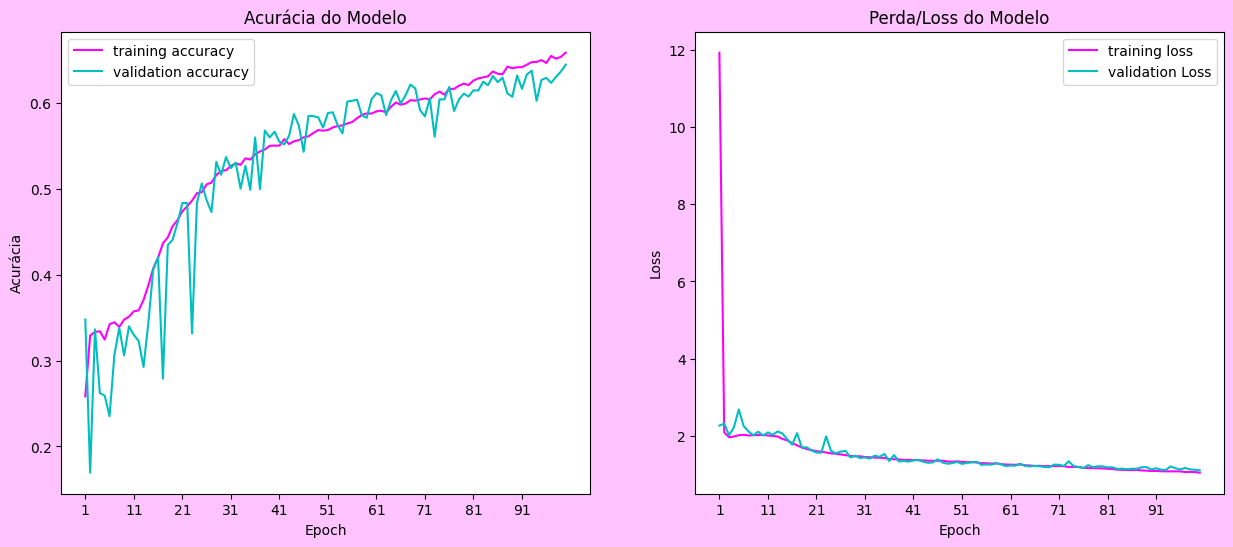

In [34]:

def plota_historico_modelo(historico_modelo):
    # Cria uma figura com duas subtramas (1 linha, 2 colunas)
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    # Muda a cor de fundo da figura para rosa claro
    fig.set_facecolor('#ffc4ff')

    # Na primeira subtrama (acurácia do modelo)
    axs[0].plot(range(1, len(historico_modelo.history['accuracy']) + 1),
                historico_modelo.history['accuracy'], '#FF00FF')  # Linha rosa para a acurácia do treinamento
    axs[0].plot(range(1, len(historico_modelo.history['val_accuracy']) + 1),
                historico_modelo.history['val_accuracy'], 'c')  # Linha ciano para a acurácia de validação
    axs[0].set_title('Acurácia do Modelo')
    axs[0].set_ylabel('Acurácia')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(historico_modelo.history['accuracy']) + 1, len(historico_modelo.history['accuracy']) // 10))
    axs[0].legend(['training accuracy', 'validation accuracy'], loc='best')  # Legenda

    # Na segunda subtrama (perda/loss do modelo)
    axs[1].plot(range(1, len(historico_modelo.history['loss']) + 1),
                historico_modelo.history['loss'], '#FF00FF')  # Linha rosa para a perda do treinamento
    axs[1].plot(range(1, len(historico_modelo.history['val_loss']) + 1),
                historico_modelo.history['val_loss'], 'c')  # Linha ciano para a perda de validação
    axs[1].set_title('Perda/Loss do Modelo')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(historico_modelo.history['loss']) + 1, len(historico_modelo.history['loss']) // 10))
    axs[1].legend(['training loss', 'validation Loss'], loc='best')  # Legenda

    # Salva a figura em um arquivo chamado 'historico_modelo_mod01.png'
    fig.savefig('historico_modelo_mod01.png')

    # Exibe a figura
    plt.show()

# Chama a função para plotar o histórico de treinamento do modelo
plota_historico_modelo(history)


### Verificando a acurácia do modelo

In [35]:
accuracy = model.evaluate(x_train, y_train)
print("Acurácia de treinamento:", accuracy[1])
print("Loss de treinamento:", accuracy[0])

# Avalia o modelo usando o conjunto de teste e obtém a acurácia e a perda
scores = model.evaluate(np.array(x_test), np.array(y_test), batch_size=batch_size)
# Imprime a acurácia do modelo
print("Acurácia de teste: " + str(scores[1]))
# Imprime a perda (loss) do modelo
print("Perda/Loss de teste: " + str(scores[0]))

accuracyval = model.evaluate(x_val, y_val)
print("Acurácia de validação:", accuracyval[1])
print("Loss de validação:", accuracyval[0])


785/785 [==============================] - 12s 15ms/step - loss: 0.8448 - accuracy: 0.7372
Acurácia de treinamento: 0.737181544303894
Loss de treinamento: 0.8448327779769897
225/225 [==============================] - 3s 15ms/step - loss: 1.1361 - accuracy: 0.6248
Acurácia de teste: 0.6248258352279663
Perda/Loss de teste: 1.1360983848571777
113/113 [==============================] - 2s 15ms/step - loss: 1.1061 - accuracy: 0.6445
Acurácia de validação: 0.6444692015647888
Loss de validação: 1.1061267852783203


## Carregando os dados para gerar a matriz de confusão dos resultados da predição da base de dados de teste

In [38]:
# Cria listas para armazenar os valores verdadeiros (true_y) e preditos (pred_y)
true_y = []
pred_y = []

# Carrega os dados do conjunto de teste a partir dos arquivos .npy
x = np.load('mod_xtest.npy')
y = np.load('mod_ytest.npy')

# Abre o arquivo JSON que contém a arquitetura do modelo previamente treinado
json_file = open(arquivo_modelo_json, 'r')
loaded_model_json = json_file.read()
json_file.close()

# Carrega o modelo a partir da arquitetura JSON e carrega os pesos
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(arquivo_modelo)

# Realiza previsões no conjunto de teste
y_pred = loaded_model.predict(x)
yp = y_pred.tolist()
yt = y.tolist()

# Inicializa uma contagem de acertos
count = 0

# Comparação dos valores verdadeiros e preditos para calcular a acurácia
for i in range(len(y)):
    yy = max(yp[i])
    yyt = max(yt[i])
    pred_y.append(yp[i].index(yy))
    true_y.append(yt[i].index(yyt))
    if (yp[i].index(yy) == yt[i].index(yyt)):
        count += 1

# Calcula a acurácia em percentagem
acc = (count / len(y)) * 100

# Salva os valores verdadeiros e preditos em arquivos .npy
np.save('truey__mod01', true_y)
np.save('predy__mod01', pred_y)

# Imprime a acurácia no conjunto de testes
print("Acurácia no conjunto de testes: " + str(acc) + "%")


225/225 [==============================] - 3s 12ms/step
Acurácia no conjunto de testes: 62.482585678461966%


## Gerando a Matriz de Confusão

In [39]:
# Importa a função confusion_matrix da biblioteca sklearn.metrics
from sklearn.metrics import confusion_matrix

# Carrega os valores verdadeiros e preditos dos arquivos .npy
y_true = np.load('truey__mod01.npy')
y_pred = np.load('predy__mod01.npy')

# Calcula a matriz de confusão
cm = confusion_matrix(y_true, y_pred)

# Define uma lista de rótulos para as expressões emocionais
expressoes = ["Raiva", "Nojo", "Medo", "Feliz", "Triste", "Surpreso", "Neutro"]

# Define um título para a matriz de confusão
titulo = 'Matriz de Confusão do reultado predição base de teste'

# Imprime a matriz de confusão
print(cm)


[[ 526   13   66   63  120   31  166]
 [  28   48    7    5    8    3    3]
 [ 124    7  333   55  242  141  141]
 [  43    1   13 1516   66   35   91]
 [ 129    6   93   70  600   17  295]
 [  21    0   62   50   18  616   28]
 [  85    0   34  108  183   22  846]]


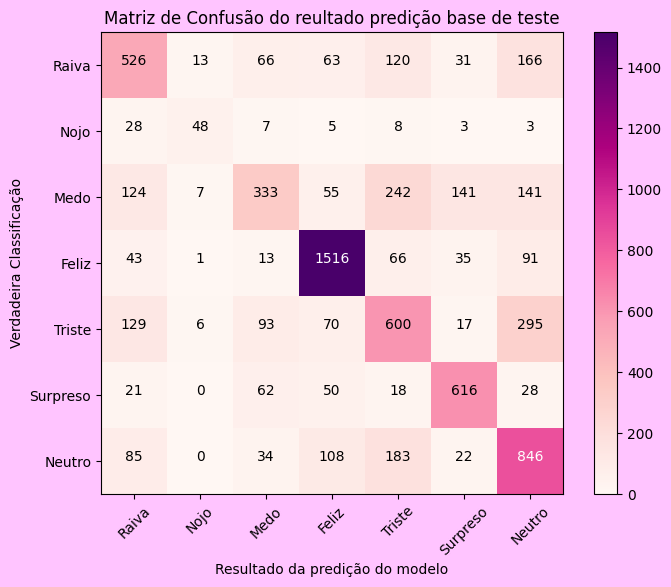

In [40]:
# Importa a biblioteca itertools para iteração eficiente
import itertools

# Especifica o mapa de cores desejado (por exemplo, 'RdPu' para tons de rosa e roxo)
cmap = plt.get_cmap('RdPu')

# Cria uma figura para a matriz de confusão
fig = plt.figure(figsize=(8, 6))

# Define a cor de fundo da figura
fig.patch.set_facecolor('#ffc4ff')

# Exibe a matriz de confusão como uma imagem com interpolação
plt.imshow(cm, interpolation='nearest', cmap=cmap)

# Define o título da figura
plt.title(titulo)

# Adiciona uma barra de cores para a matriz de confusão
plt.colorbar()

# Define os rótulos dos eixos x e y com as expressões emocionais
tick_marks = np.arange(len(expressoes))
plt.xticks(tick_marks, expressoes, rotation=45)
plt.yticks(tick_marks, expressoes)

# Formata os valores na matriz de confusão
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

# Define rótulos para os eixos x e y
plt.ylabel('Verdadeira Classificação')
plt.xlabel('Resultado da predição do modelo')

# Salva a figura como 'matriz_confusao_mod01.png'
plt.savefig('matriz_confusao.png')

# Exibe a figura
plt.show()


## Testando o modelo em imagens estática

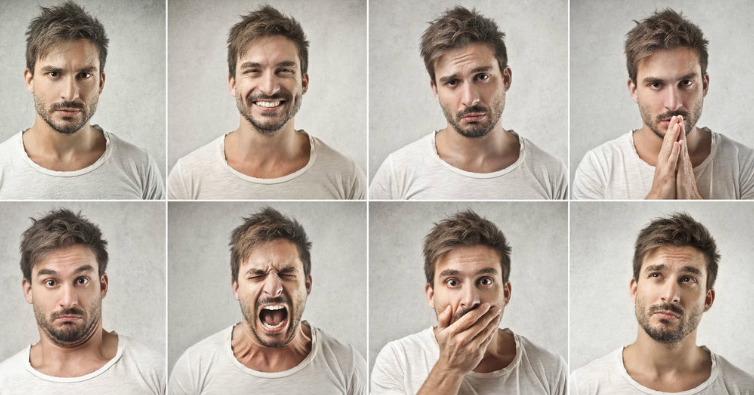

In [23]:
# Lê a imagem do arquivo "teste02.jpg"
imagem = cv2.imread("/content/drive/MyDrive/IAExpert/Material/testes/teste02.jpg")

# Exibe a imagem
cv2_imshow(imagem)

In [41]:
# Carrega o modelo treinado a partir do arquivo
model = load_model("/content/modelo_expressoes1.h5")

# Avalia o modelo nos dados de teste
scores = model.evaluate(np.array(x_test), np.array(y_test), batch_size=batch_size)
print("Perda/Loss: " + str(scores[0]))
print("Acurácia: " + str(scores[1]))


225/225 [==============================] - 4s 15ms/step - loss: 1.1361 - accuracy: 0.6248
Perda/Loss: 1.1360983848571777
Acurácia: 0.6248258352279663


1/1 [==============================] - 0s 18ms/step


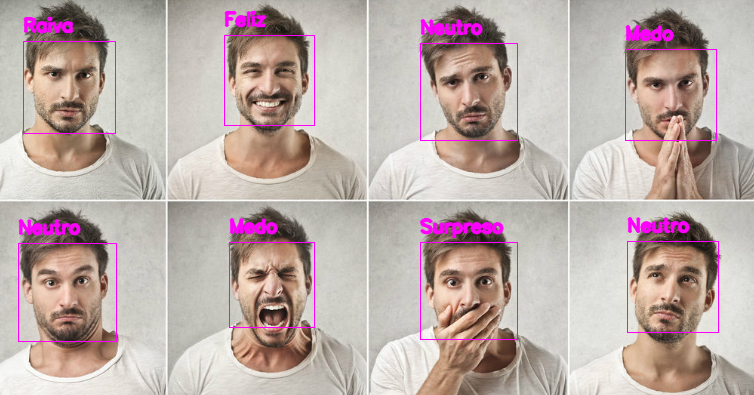

In [42]:
# Importe as bibliotecas necessárias
expressoes = ["Raiva", "Nojo", "Medo", "Feliz", "Triste", "Surpreso", "Neutro"]
original = imagem.copy()  # Faz uma cópia da imagem original para manter a original intocada
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)  # Converte a imagem em tons de cinza para detecção mais eficaz
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/IAExpert/Material/haarcascade_frontalface_default.xml')  # Carregue o classificador em cascata Haar para detecção de rostos
faces = face_cascade.detectMultiScale(gray, 1.1, 3)  # Detecta os rostos na imagem

# Itera sobre cada rosto detectado
for (x, y, w, h) in faces:
    cv2.rectangle(original, (x, y), (x + w, y + h), (255, 0, 255), 1)  # Desenha um retângulo ao redor do rosto detectado
    roi_gray = gray[y:y + h, x:x + w]  # Extrai a região de interesse (ROI) em tons de cinza
    roi_gray = roi_gray.astype("float") / 255.0  # Normaliza os valores de pixel entre 0 e 1
    cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)  # Redimensiona e prepare a imagem para alimentar o modelo
    cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)  # Normaliza a imagem de entrada
    prediction = model.predict(cropped_img)[0]  # Faz uma previsão da expressão facial no rosto
    cv2.putText(original, expressoes[int(np.argmax(prediction))], (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 255), 2, cv2.LINE_AA)  # Escreve a expressão prevista no rosto

cv2_imshow(original)  # Mostra a imagem original com as previsões
